# Анализ данных по методологии CrispDM

# 1. Понимание бизнеса

1.1 Цель

Предсказать качество вина на основе его физико-химических признаков

1.2 Описание

Цель проекта - используя методы моделирования предсказать качестве вин. Набор данных относится к красному и белому вариантам португальского вина "Винью Верде". Из-за проблем с конфиденциальностью и логистики доступны только физико-химические (исходные) и сенсорные (выходные) переменные (например, нет данных о сортах винограда, марке вина, продажной цене вина и т. Д.).

Эти наборы данных можно рассматривать как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, нормальных вин едят больше, чем отличных или плохих). Алгоритмы обнаружения выбросов могут использоваться для обнаружения нескольких отличных или плохих вин. Кроме того, мы не уверены, все ли входные переменные актуальны. Так что было бы интересно протестировать методы выбора функций.

Два набора данных были объединены, и несколько значений были удалены случайным образом.

https://www.kaggle.com/datasets/rajyellow46/wine-quality

# 2. Data Understanding

2.1 Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline

2.2 Вспомогательные функции

In [2]:
def plot_correlation_map(df):
    corr = df.corr()
    _, ax = plt.subplots(figsize=(12, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    _ = sns.heatmap(
        corr,
        cmap=cmap,
        square=True,
        cbar_kws={'shrink': .9},
        ax=ax,
        annot=True,
        annot_kws={'fontsize': 12}
    )


def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(0, df[var].max()))
    facet.add_legend()


def plot_variable_importance(X, y):
    tree = DecisionTreeClassifier(random_state=99)
    tree.fit(X, y)
    plot_model_var_imp(tree, X, y)


def plot_model_var_imp(model, X, y):
    imp = pd.DataFrame(
        model.feature_importances_,
        columns=['Importance'],
        index=X.columns
    )
    imp = imp.sort_values(['Importance'], ascending=True)
    imp[: 10].plot(kind='barh')
    print(model.score(X, y))

2.3 Загрузка данных

In [58]:
wine = pd.read_csv('C:/DS/Netology/winequalityN.csv')

2.4 Статистика и визуализации

In [59]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [60]:
wine.sample(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4170,white,7.4,0.16,0.30,13.7,0.056,33.0,168.0,0.99825,2.90,0.44,8.7,7
1956,white,7.2,0.15,0.33,1.1,0.027,16.0,63.0,0.99370,3.37,0.40,9.9,5
426,white,7.0,0.21,0.28,8.6,0.045,37.0,221.0,0.99540,3.25,0.54,10.4,6
3869,white,6.2,0.22,0.30,12.4,0.054,108.0,152.0,0.99728,3.10,0.47,9.5,6
5884,red,9.8,0.34,0.39,1.4,0.066,3.0,7.0,0.99470,3.19,0.55,11.4,7
2014,white,9.0,0.55,0.30,8.1,0.026,14.0,71.0,0.99300,2.94,0.36,11.8,5
5228,red,10.2,0.36,0.64,2.9,0.122,10.0,41.0,0.99800,3.23,0.66,12.5,6
687,white,6.8,0.67,0.30,13.0,0.290,22.0,193.0,0.99840,3.08,0.67,9.0,4
1446,white,6.3,0.27,0.49,1.2,0.063,35.0,92.0,0.99110,3.38,0.42,12.2,6
2351,white,7.9,0.25,0.34,11.4,0.040,53.0,202.0,0.99708,3.11,0.57,9.6,6


Описание переменных

Входные переменные: 1 - fixed acidity - фиксированная кислотность 2 - volatile acidity - летучая кислотность 3 - citric acid - лимонная кислота 4 - residual sugar - остаточный сахар 5 - chlorides - хлориды 6 - free sulfur dioxide - свободный диоксид серы 7 - total sulfur dioxide - общий диоксид серы 8 - density - плотность 9 - pH 10 - sulphates - сульфаты 11 - alcohol - спирт

Выходная переменная: 12 - quality (score between 0 and 10)

https://www.kaggle.com/c/wine-quality/data

2.4.1 Далее взглянем на некоторую ключевую информацию о переменных

In [8]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

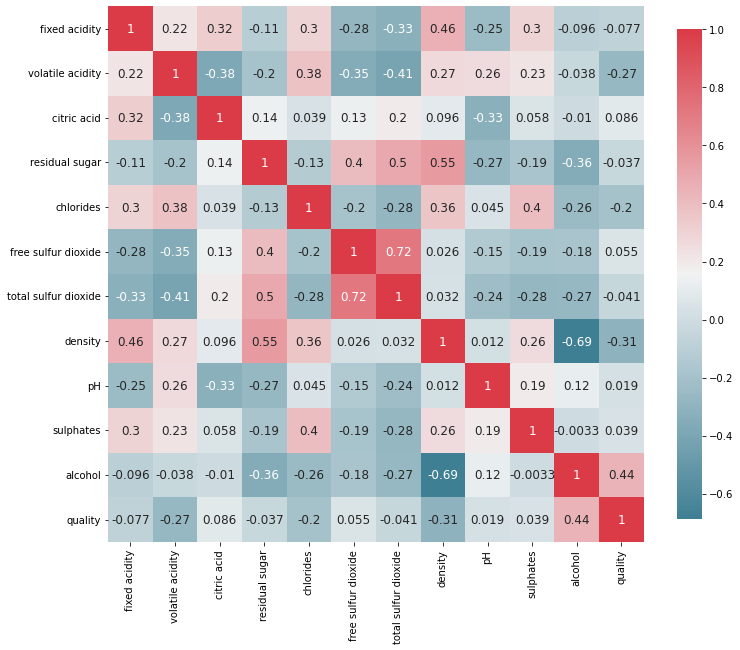

In [9]:
plot_correlation_map(wine)

2.4.3 Рассмотрим взаимосвязь между признаками и качеством вина

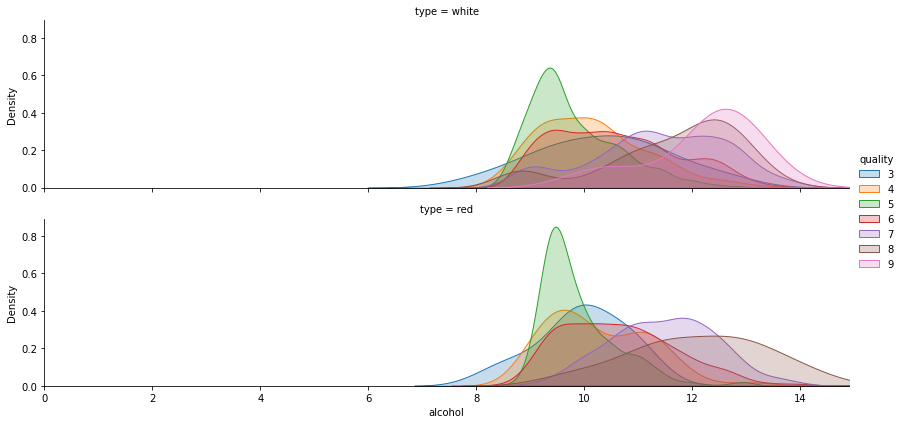

In [10]:
plot_distribution(wine, var='alcohol', target='quality', row='type')

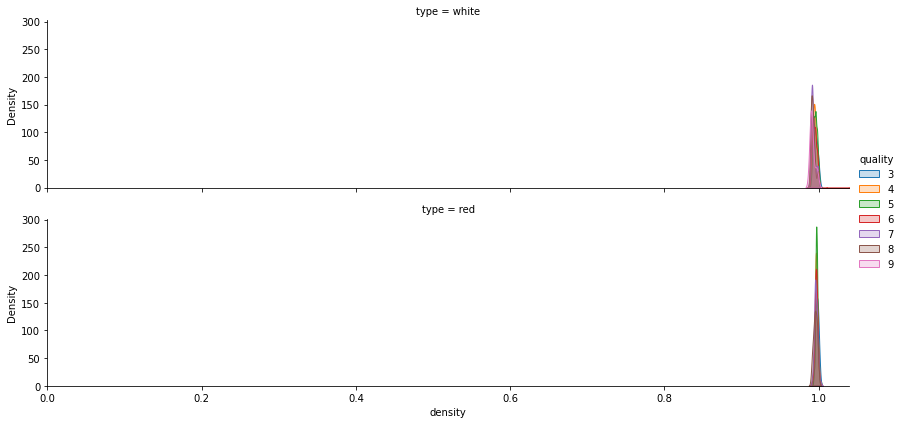

In [11]:
plot_distribution(wine, var='density', target='quality', row='type')

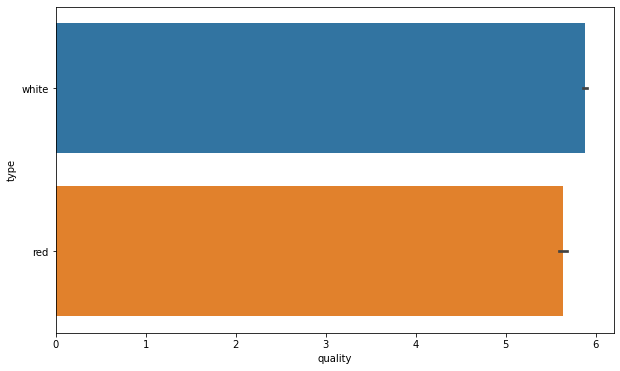

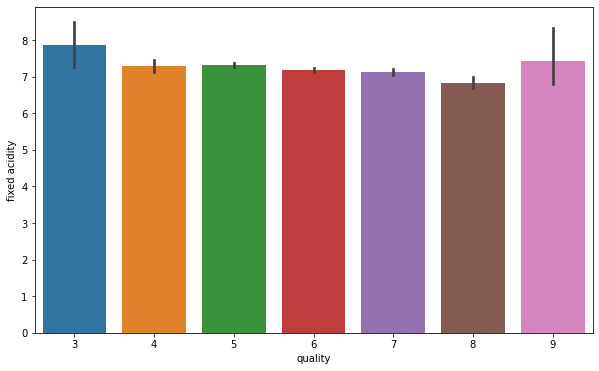

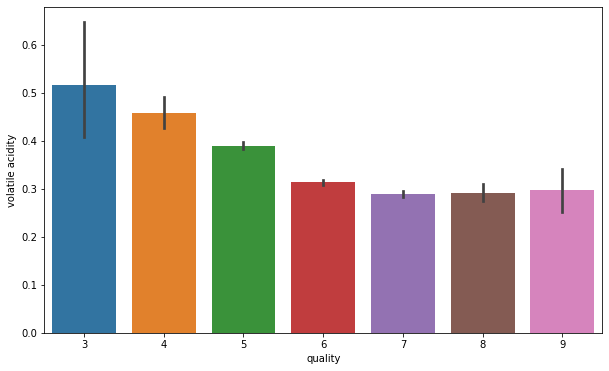

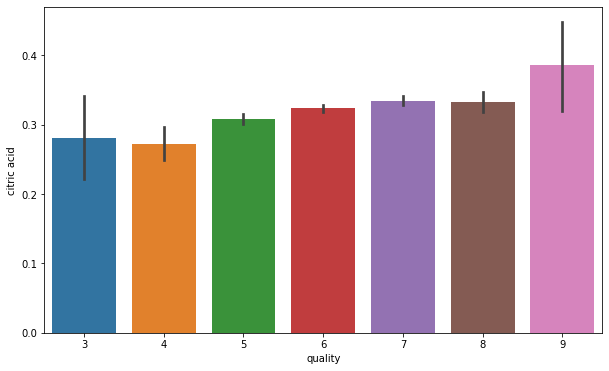

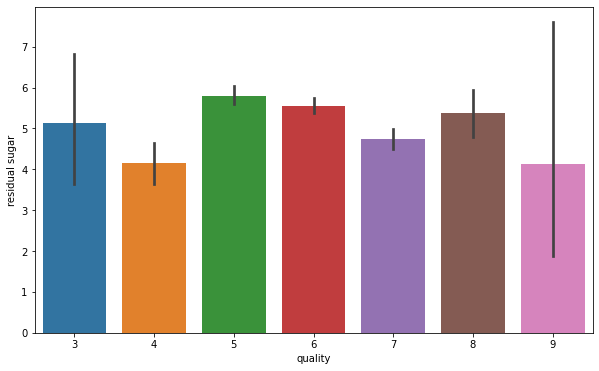

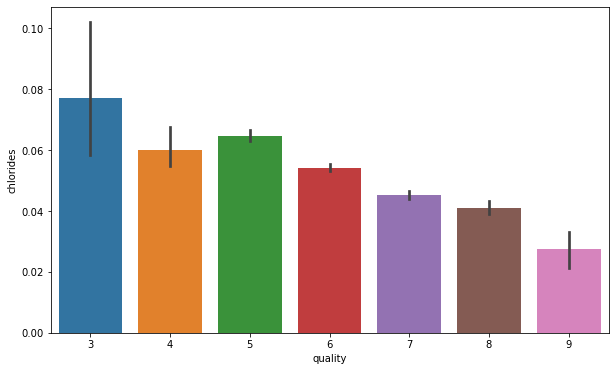

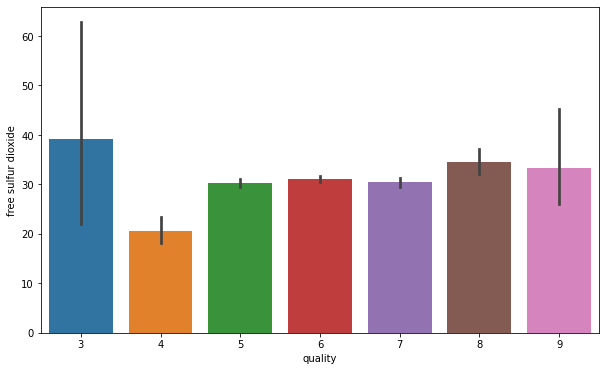

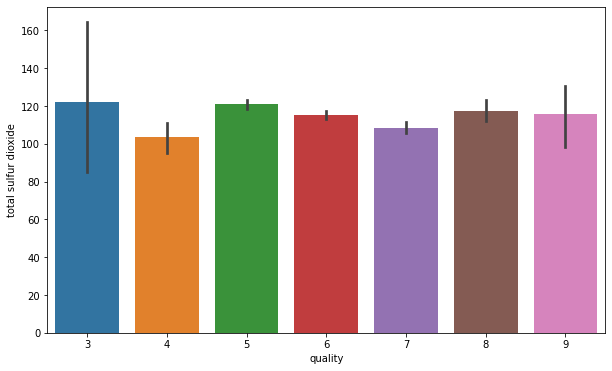

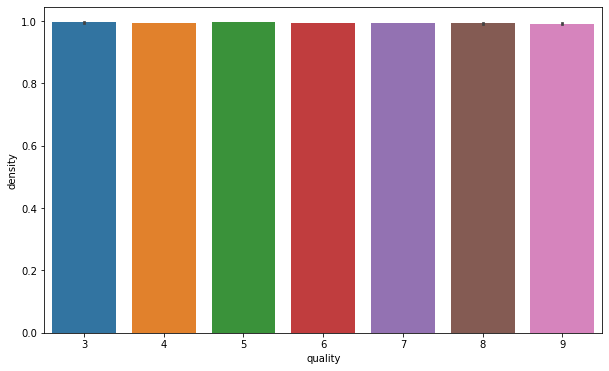

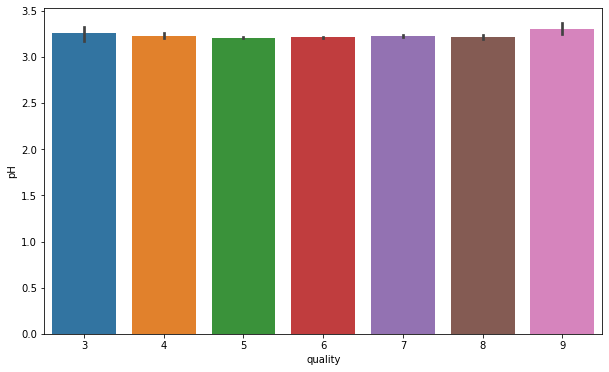

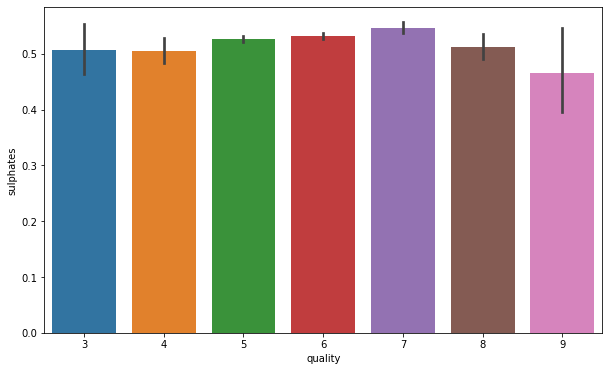

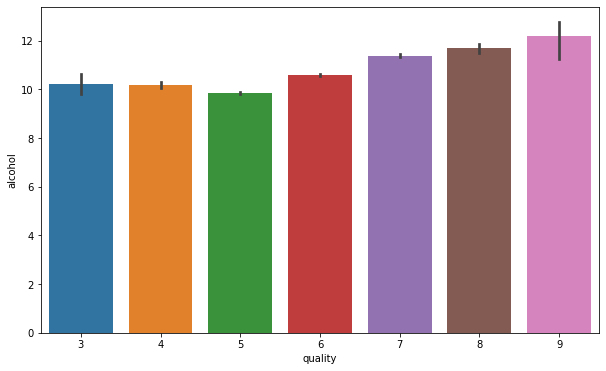

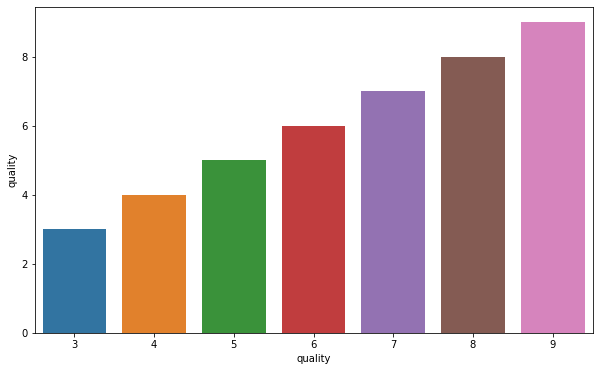

In [12]:
for column in wine.columns:
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(x='quality', y=column, data=wine)

Рассмотрим графики выше. Различия между видами вина для разных показателей - это то, что будет использоваться для разделения целевой переменной (в данном случае - вид вина) в модели. Если бы две линии были примерно одинаковыми, то это не было бы хорошей переменной для нашей прогностической модели. В основном показатели ведут себя различно.

# 3. Подготовка данных

3.1 Категориальные переменные преобразовываем в числовые

In [31]:
quality = pd.get_dummies( wine['quality'] , prefix='качество' )
quality.head()

,качество_0,качество_1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


3.2 Заполняем пропущенные значения в переменных

In [37]:
columns = ['fixed acidity', 'volatile acidity','citric acid','residual sugar',	'chlorides', 'pH','sulphates']

In [43]:
# Create dataset
imputed = pd.DataFrame()

for i in range(len(columns)):
# Fill missing values of Age with the average of Age (mean)
    imputed[ columns[i] ] = wine[columns[i]].fillna( wine[columns[i]].mean() )

imputed.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,pH,sulphates
0,7.0,0.27,0.36,20.7,0.045,3.00,0.45
1,6.3,0.30,0.34,1.6,0.049,3.30,0.49
2,8.1,0.28,0.40,6.9,0.050,3.26,0.44
3,7.2,0.23,0.32,8.5,0.058,3.19,0.40
4,7.2,0.23,0.32,8.5,0.058,3.19,0.40


3.3 Отбор признаков

In [41]:
# создаем датасет с неиспользованными ни где колонками.
wine_ = wine[['free sulfur dioxide','total sulfur dioxide','density','alcohol']]

In [42]:
full_X = pd.concat( [ imputed , wine_ , quality ] , axis=1 )
full_X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,pH,sulphates,free sulfur dioxide,total sulfur dioxide,density,alcohol,качество_0,качество_1
0,7.0,0.27,0.36,20.7,0.045,3.00,0.45,45.0,170.0,1.0010,8.8,1,0
1,6.3,0.30,0.34,1.6,0.049,3.30,0.49,14.0,132.0,0.9940,9.5,1,0
2,8.1,0.28,0.40,6.9,0.050,3.26,0.44,30.0,97.0,0.9951,10.1,1,0
3,7.2,0.23,0.32,8.5,0.058,3.19,0.40,47.0,186.0,0.9956,9.9,1,0
4,7.2,0.23,0.32,8.5,0.058,3.19,0.40,47.0,186.0,0.9956,9.9,1,0


3.4 Создание датасетов

In [61]:
# Create all datasets that are necessary to train, validate and test models
X = full_X
y = wine['type']
train_valid_X , test_X , train_valid_y , test_y = train_test_split( X , y , train_size = .9, random_state = 42 )

train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7, random_state = 42 )

print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape )

(6497, 13) (4092, 13) (1755, 13) (4092,) (1755,)


0.9997556207233627


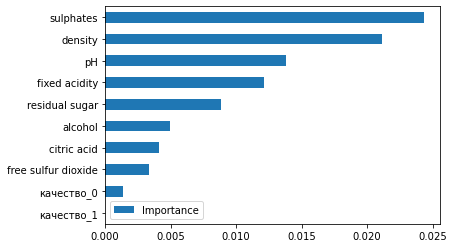

In [62]:
plot_variable_importance(train_X, train_y)

# 4. Моделирование

4.1 Выбор модели

In [63]:
model = LogisticRegression()

4.2 Обучение модели

In [64]:
model.fit( train_X , train_y )

C:\DS\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# 5. Оценка

Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)



In [65]:
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.9811827956989247 0.9794871794871794
